# ANN - LSTM - Microsoft Stock Prediction

## Introduction

### Práctica. Predicción de Acción de Microsoft

As you know it is quite difficult to predict the stock market value as future values are independent of past values, but what we can see is the sign of the trend, if it is positive the stock will go up and if it is negative it will go down.

To do this we use the API of the yahoo finance portal and using the yfinance python library we connect and extract the data for 7 years Microsoft stock market price.

## 1. Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

## 2. Load datasets

In [2]:
msft = yf.Ticker('msft')

Fields we have are:

* Date: the indexed date.
* Open: opening value of the day where the stock is listed.
* High: highest daily value.
* Low: lowest daily value.
* Close: closing value
* Volume: volume of shares traded on the day (both bought and sold).
* Dividends: if dividends have been paid during the day.
* Stock Splits: if stock splits have been made.

We will work with the Open value, the value of the stock at the opening of the stock market.

In [3]:
df = msft.history(period='7y')
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-03-28 00:00:00-04:00,48.828381,48.900440,48.035744,48.224895,17025100,0.0,0
2016-03-29 00:00:00-04:00,48.332997,49.413869,48.143845,49.278759,23924300,0.0,0
2016-03-30 00:00:00-04:00,49.476917,50.116432,49.449896,49.585003,23008300,0.0,0
2016-03-31 00:00:00-04:00,49.494929,50.071393,49.413863,49.747131,26360500,0.0,0
2016-04-01 00:00:00-04:00,49.585001,50.089409,49.152652,50.053379,24399200,0.0,0


Analysing the value series over the entire history, we see that it peaks at the end of the year 2021 and with the beginning of the year 2022 starts a negative trend.

## 3. Dataset analysis

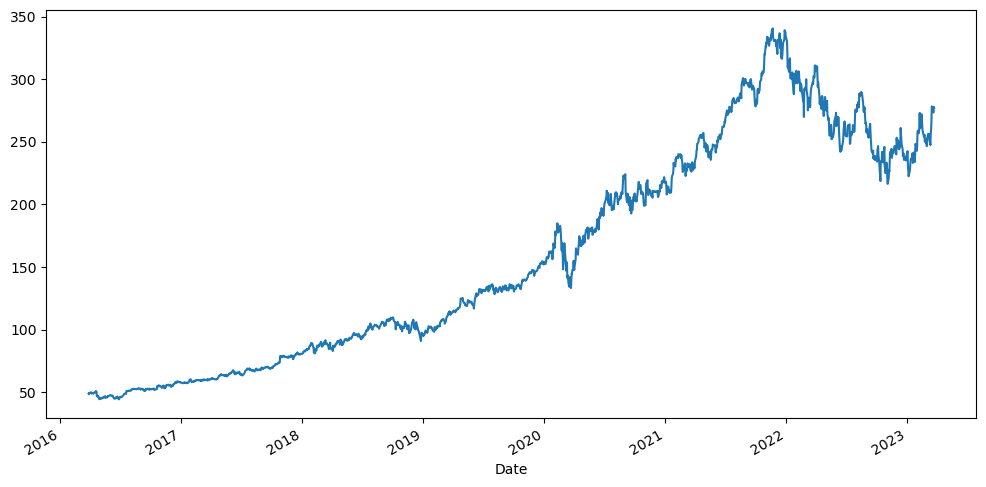

In [4]:
df.Open.plot(figsize=(12,6));

Select by date the training dataset.

In [5]:
df_train = df.loc['2016-01-01':'2021-12-31']
df_train.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-02-18 00:00:00-05:00,47.135035,47.693484,46.927865,47.008930,27176000,0.0,0
2016-02-19 00:00:00-05:00,46.810766,47.089989,46.414444,46.675655,33559100,0.0,0
2016-02-22 00:00:00-05:00,47.089973,47.738497,47.089973,47.423244,25008300,0.0,0
2016-02-23 00:00:00-05:00,47.144029,47.171049,45.919040,46.099186,28895300,0.0,0
2016-02-24 00:00:00-05:00,45.657830,46.387419,45.216475,46.261318,33014500,0.0,0


Select the Open column and convert it into a numpy array.

In [6]:
training_set  = df_train.iloc[:, 0:1].values
training_set

array([[ 47.13503484],
       [ 46.81076574],
       [ 47.08997325],
       ...,
       [337.28684856],
       [337.88968123],
       [334.52966897]])

Scale the training df, there are two ways to do this:

* Standardize: subtract by the mean and divide by the standard deviation to have an N(0,1).
* Normalise: subtract by the minimum and divide by the range (max - min) to get a range (0,1).

We can use either of the two, but the most recommended whenever we have a sigmoid activation function in the network execution is to use the minmax normalisation since we use the same range and the LSTM uses sigmoid in the windows.

We use fit_transform to apply the formula and transform the variable in the same step.

In [7]:
sc = MinMaxScaler(feature_range = (0, 1)) # default is (0,1)
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled

array([[0.00932929],
       [0.00823451],
       [0.00917715],
       ...,
       [0.98892307],
       [0.99095832],
       [0.97961444]])

In the next step we generate the input to the LSTM, generating the sequence values, we are going to use 60 values that we will load in X_train and the next immediate value in y_train. What we want is that the LSTM trains with the 60 values and predicts the next value, so successively we iterate through the whole training df. Why 60? You can try with different values, one month (20 days), two months (40 days) ... I have taken a quarter because normally the companies present results every quarter and it is a sufficient number to estimate.

In [8]:
X_train = []
y_train = []
for i in range(60, len(df_train)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

Visualise the array as a training dataframe so that we can see the sequence matrix generated as input to the LSTM. Where in each row we have 60 observations and you can see that each time we iterate the values move one position.

In [9]:
# Visualise the array as a dataframe

pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,0.009329,0.008235,0.009177,0.009360,0.004342,0.007505,0.010150,0.006349,0.005193,0.009573,...,0.000267,0.002244,0.003278,0.001757,0.001848,0.002000,0.003734,0.003247,0.005680,0.005893
1,0.008235,0.009177,0.009360,0.004342,0.007505,0.010150,0.006349,0.005193,0.009573,0.011275,...,0.002244,0.003278,0.001757,0.001848,0.002000,0.003734,0.003247,0.005680,0.005893,0.006623
2,0.009177,0.009360,0.004342,0.007505,0.010150,0.006349,0.005193,0.009573,0.011275,0.009542,...,0.003278,0.001757,0.001848,0.002000,0.003734,0.003247,0.005680,0.005893,0.006623,0.004677
3,0.009360,0.004342,0.007505,0.010150,0.006349,0.005193,0.009573,0.011275,0.009542,0.006988,...,0.001757,0.001848,0.002000,0.003734,0.003247,0.005680,0.005893,0.006623,0.004677,0.008574
4,0.004342,0.007505,0.010150,0.006349,0.005193,0.009573,0.011275,0.009542,0.006988,0.004677,...,0.001848,0.002000,0.003734,0.003247,0.005680,0.005893,0.006623,0.004677,0.008574,0.004777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1415,0.801709,0.789753,0.807338,0.796181,0.801942,0.833248,0.836711,0.825721,0.833781,0.832349,...,0.967837,0.986854,0.961965,0.946584,0.970272,0.920793,0.918024,0.928834,0.945549,0.960396
1416,0.789753,0.807338,0.796181,0.801942,0.833248,0.836711,0.825721,0.833781,0.832349,0.846669,...,0.986854,0.961965,0.946584,0.970272,0.920793,0.918024,0.928834,0.945549,0.960396,0.969438
1417,0.807338,0.796181,0.801942,0.833248,0.836711,0.825721,0.833781,0.832349,0.846669,0.857093,...,0.961965,0.946584,0.970272,0.920793,0.918024,0.928834,0.945549,0.960396,0.969438,0.995095
1418,0.796181,0.801942,0.833248,0.836711,0.825721,0.833781,0.832349,0.846669,0.857093,0.861190,...,0.946584,0.970272,0.920793,0.918024,0.928834,0.945549,0.960396,0.969438,0.995095,0.988923


In [10]:
pd.DataFrame(y_train)

,0
0,0.006623
1,0.004677
2,0.008574
3,0.004777
4,0.004746
...,...
1415,0.969438
1416,0.995095
1417,0.988923
1418,0.990958


Add a new dimension to the training df (X_train):

* Number of observations of X_train.
* Number of sequences of X_train, it is the number of columns that we have created when sequencing.
* Depth of the dataframe, this refers to the number of variables, in our case 1, the value of the Microsoft action, if we use other variables (exogenous) we will extend the dimensionality and we must include it in X_train.

In [11]:
X_train.shape

(1420, 60)

## 4. Train model

In [5]:
X_train = np.reshape(X_train, # Dataframe to resize
                     (X_train.shape[0], # Number of observations
                      X_train.shape[1], # Number of sequences (number of columns)
                      1) # Depth
                    )
X_train.shape

NameError: name 'X_train' is not defined

In [13]:
X_train

array([[[0.00932929],
        [0.00823451],
        [0.00917715],
        ...,
        [0.00324727],
        [0.00568004],
        [0.00589292]],

       [[0.00823451],
        [0.00917715],
        [0.00935965],
        ...,
        [0.00568004],
        [0.00589292],
        [0.00662276]],

       [[0.00917715],
        [0.00935965],
        [0.00434203],
        ...,
        [0.00589292],
        [0.00662276],
        [0.00467654]],

       ...,

       [[0.80733765],
        [0.79618086],
        [0.80194233],
        ...,
        [0.96039638],
        [0.96943811],
        [0.99509544]],

       [[0.79618086],
        [0.80194233],
        [0.83324785],
        ...,
        [0.96943811],
        [0.99509544],
        [0.98892307]],

       [[0.80194233],
        [0.83324785],
        [0.83671144],
        ...,
        [0.99509544],
        [0.98892307],
        [0.99095832]]])

Now we are ready to create the LSTM structure. We will create a structure with an input layer, 3 LSTM layers with Dropout overfitting prevention and an output layer with prediction value. Initialise it as a sequential set of layers and call it a regressor because we are in a regression problem to predict a numerical value.

In [14]:
regressor = Sequential()

In [15]:
regressor.add(LSTM(units = 50, # num. od neurons
                   return_sequences = True, # return all neurons
                   input_shape = (X_train.shape[1], X_train.shape[2]) )) # size input form, must match X_train

We add several layers in a row with a Dropout of 0.5 to prevent overfitting (remember to randomly disable neurons at the given %, in our example 50% of them).

In [16]:
regressor.add(LSTM(units = 50, return_sequences = True ))
regressor.add(Dropout(0.5))

In [17]:
regressor.add(LSTM(units = 50, return_sequences = True ))
regressor.add(Dropout(0.5))

In [18]:
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.5))

Add the output layer, as we want to predict the value of a value for each sequence, the value of units must be 1.

In [19]:
regressor.add(Dense(units = 1))

Compile with optimiser adam (for recurrence adam or RMSprop is recommended, although adam usually gives better results) and cost function MSE because it is a regression model.

In [20]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

Train 100 epochs (enough for the network to converge, you can try more and less to compare the output) with batch_size of 32 (remember that they work best with powers of 2). We see that there are 46 (n.obs / batch_size) backpropagation processes.

In [21]:
history = regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
45/45 [==============================] - 92s 261ms/step - loss: 0.0249
Epoch 2/100
45/45 [==============================] - 12s 257ms/step - loss: 0.0074
Epoch 3/100
45/45 [==============================] - 12s 256ms/step - loss: 0.0059
Epoch 4/100
45/45 [==============================] - 12s 262ms/step - loss: 0.0063
Epoch 5/100
45/45 [==============================] - 12s 264ms/step - loss: 0.0053
Epoch 6/100
45/45 [==============================] - 10s 216ms/step - loss: 0.0051
Epoch 7/100
45/45 [==============================] - 6s 133ms/step - loss: 0.0057
Epoch 8/100
45/45 [==============================] - 4s 96ms/step - loss: 0.0042
Epoch 9/100
45/45 [==============================] - 4s 92ms/step - loss: 0.0056
Epoch 10/100
45/45 [==============================] - 5s 106ms/step - loss: 0.0047
Epoch 11/100
45/45 [==============================] - 4s 93ms/step - loss: 0.0041
Epoch 12/100
45/45 [==============================] - 4s 90ms/step - loss: 0.0035
Epoch 13/10

After training the network, we plot the cost function to see how the error has evolved, saving it in the history object. We can see how it starts with a high error and decreases and consolidates from epoch 60 onwards.

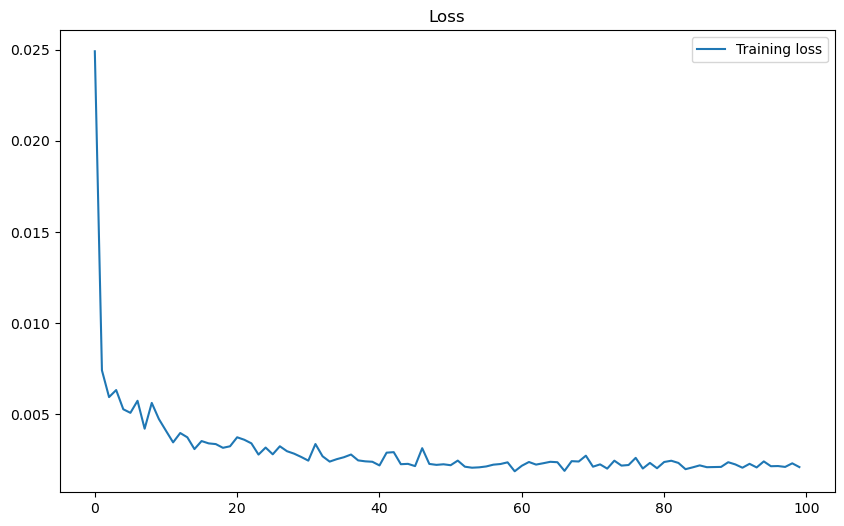

In [22]:
plt.figure(figsize=(10,6))
loss = history.history['loss']

plt.plot(range(len(loss)),loss, label='Training loss')
plt.title('Loss')
plt.legend()

plt.show();

Overview of the network created with summary:

In [23]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0

We generate the Test df, selecting the 5 months of 2022.

In [24]:
df_test = df.loc['2022-01-01':'2022-05-31']

real_stock_price = df_test.iloc[:, [0]].values
df_test.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-01-03 00:00:00-05:00,331.406824,334.025658,325.902311,330.813873,28865100,0.0,0
2022-01-04 00:00:00-05:00,330.892931,331.258606,322.285355,325.141388,32674300,0.0,0
2022-01-05 00:00:00-05:00,322.028361,322.235914,312.264561,312.659851,40054300,0.0,0
2022-01-06 00:00:00-05:00,309.467843,314.952602,307.827358,310.189270,39646100,0.0,0
2022-01-07 00:00:00-05:00,310.456074,312.778447,306.443815,310.347382,32720000,0.0,0


Now that we have the trained network we are going to predict the values of the year 2022, as we have used a sequence of 60 days in the training df, we are going to generate a dataframe with the necessary observations to estimate 2022. 

For this we select all the test observations plus the last 60 observations of the training df. We must be sure that the shape of the data corresponds to the input to the network to avoid errors, in our case we start from a row vector with all the observations, so we have to modify it to have a column vector (we use numpy reshape). 

Once the observations have been selected and the shape has been modified, we have to scale the data, but be careful using the transformation used with the training df, it is possible that now in our new df we have values higher than the max of training and a min lower than the training df, the important thing is that it is transformed using the same values with which the network was trained. For this we use the transform function and not fit_transform. If we don't scale the prediction will not make sense.

Once scaled we have to generate the sequential structure of 60 obs for each value we are going to predict as we did before with the training dataframe.

In [25]:
# Merge the training and test data to be able to scale with all values together for the Open column.

df_total = pd.concat((df_train['Open'], df_test['Open']), axis = 0)
print(len(df_total))
print(len(df_train))
print(len(df_test))

# Generate the df based on the 60-day sequence.

inputs = df_total[len(df_total) - len(df_test) - 60:].values
print(len(inputs))
print(inputs.shape)

# In the previous step has generated a one-dimensional vector, this format is not valid as input in the
# Models but we need a column vector, for this we have to change the shape.
inputs = inputs.reshape(-1,1)
print(inputs.shape)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(df_test)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

1583
1480
103
163
(163,)
(163, 1)


(43, 60, 1)

Once we have generated our test dataframe according to the training of the network, we generate the prediction and reverse the scaling so that we can compare it with the real values of the stock. We can see in the graph how the structure applied as we move through the 2022 dates identifies the change in trend correctly.

2/2 [==============================] - 2s 23ms/step


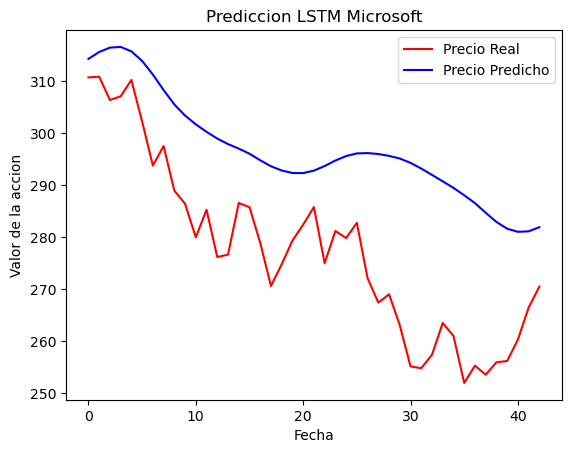

In [26]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Visualizar los Resultados
plt.plot(real_stock_price[60:len(real_stock_price)], color = 'red',
         label = 'Real Price')
plt.plot(predicted_stock_price, color = 'blue',
         label = 'Predicted Price')
plt.title("LSTM Microsoft Prediction")
plt.xlabel("Date")
plt.ylabel("Stock Market Price")
plt.legend()
plt.show()

In [53]:
mape_lstm = np.mean(np.abs(real_stock_price[60:len(real_stock_price)] - predicted_stock_price)/np.abs(real_stock_price[60:len(real_stock_price)]))    # MAPE
smape_lstm = 1/len(predicted_stock_price) * np.sum(np.abs(real_stock_price[60:len(real_stock_price)] - predicted_stock_price) / (np.abs(predicted_stock_price) + np.abs(real_stock_price[60:len(real_stock_price)]))) # sMAPE

In [54]:
mape_lstm

0.07183058309102358

In [55]:
smape_lstm

0.03434772589754229

Our prediction has a 7% of error regards MAPE or a 3,4% of error taking in account SMAPE